In the first week of the Fast.ai course, we saw how you could fine tune a pre-trained model like resnet34 to recogonize objects of interest. There were lots of interesting projects last week ranging from classifing Dog breeds to Devanagiri Scripts. We were interested in checking out the if similar approach could be used to recogonize a person's emotion from thier face expression

Data Gathering
-------

First we need to gather some labeled data, Our first approach was to build our own data set from google images. We wanted this classifier to work only based on the facial expression rather than the environment the person is in, so we needed a way to crop just the face out from every pic. After few google/stack-overflow searches, we found out the following code based open-cv can get the bounding boxes of all the faces in the image.

```python
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
def get_faces(file_path):
    im = cv2.imread(file_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im_copy = np.copy(im)
    # the classifier works on grey-scale image
    gray_image = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray_image, 1.25, 6)
    face_crop = []
    for f in faces:
        x, y, w, h = [v for v in f]
        face_crop.append(im_copy[y:y + h, x:x + w])
    return face_crop
```
But it seemed like the data set gathered this way would need some manual cleaning, removing non-faces, emoji etc. So we were looking for any pre-curated data set that was used in academia, and to our suprise there is actually a wikipedia page dedicated to [facial expressions datasets](https://en.wikipedia.org/wiki/Facial_expression_databases). We choose to work with [AffectNet Dataset](http://mohammadmahoor.com/wp-content/uploads/2017/08/AffectNet_oneColumn-2.pdf) because,
* The images we in *wild setting* and were not posed, this would be a better choice if we want the trained model to predict in real life scenarios.
* All the 450,000 were manually annotated by twelve human experts

**We would like to thank the authors for being kind enough to share the data set with us :-)**

Pre-processing
------------

The data set was huge upwards, of 55 GB (just the manually annotated part), The dataset contains total of `420300` images which were split in to `training`(414800 images) and `validation`(5500 images), Currently the authors have not released the test set. Since the validation set was only 1.3 % of the total data, we decided to combine them both and let fastai library to make the test train splits for us.

In [1]:
import pandas as pd
from pathlib2 import Path

In [2]:
path = Path("/home/gokul/Data/AffectNet/")

In [3]:
df_train = pd.read_csv(path/'training.csv')

In [4]:
df_val = pd.read_csv(path/'validation.csv')

In [5]:
df_train.shape

(414800, 9)

In [6]:
df_val.shape

(5500, 9)

In [ ]:
folders = list((path/"Manually_Annotated_Images").iterdir())
files = []

for folder in folders:
    files += list(folder.iterdir())

print(f"No of images: {len(files)}")

In [7]:
df = pd.concat([df_train, df_val])

In [8]:
df.reset_index(inplace=True)

The data was divided into 11 classes. Namely `[Neutral, Happiness, Sadness, Surprise, Fear, Disgust, Anger, Contempt, None, Uncertain, Non-Face]`. For simplicity we will consider the situation where-in the pics sent to model will always contain a face in it, and hence we dropped `No-Face` category, and we also dropped `No-Expression` & `Uncertain` category as those can be represented by `Neutral`. Thus our training ended up with only 8 classes.

In [9]:
emotional_categories = {0: 'Neutral', 1: 'Happiness', 2: 'Sadness',
                        3: 'Surprise', 4: 'Fear', 5: 'Disgust', 6: 'Anger',
                        7: 'Contempt', 8: 'No-Expression', 9: 'Uncertain',
                        10: 'No-Face'
                       }

In [10]:
df.shape

(420300, 10)

Let's examine the metadata, it contains `subDirectory_filePath` which is the relative path to images, we have `(face_x, face_y, face_width, face_height)` which defines the bounding box of the face in the image, we will use this bounding box data to crop just the face from the image. For this project we will ignore `(facial_landmarks, valence and arousal)` columns.

In [11]:
df.head(2).T

,0,1
index,0,1
subDirectory_filePath,689/737db2483489148d783ef278f43f486c0a97e140fc...,392/c4db2f9b7e4b422d14b6e038f0cdc3ecee239b5532...
face_x,134,20
face_y,134,20
face_width,899,137
face_height,899,137
facial_landmarks,181.64;530.91;188.32;627.82;195.1;723.37;205.2...,28.82;77.52;29.12;93.25;31.04;108.51;33.03;123...
expression,1,0
valence,0.785714,-0.0172533
arousal,-0.0555556,0.00431332


In [12]:
import matplotlib.pyplot as plt

In [13]:
import cv2

def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [14]:
first = df.loc[:5, :].to_dict('records')[0]
# first

(1167, 1167, 3)


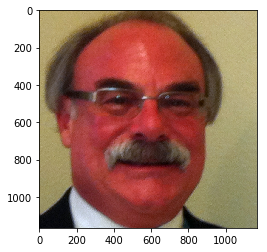

In [15]:
im = read_image(path/'Manually_Annotated_Images'/first['subDirectory_filePath'])
plt.imshow(im)
print(im.shape)

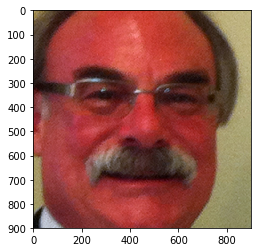

In [16]:
im_crop = im[int(first['face_x']):int(first['face_x'] + first['face_width']),
             int(first['face_y']):int(first['face_y'] + first['face_height'])]
plt.imshow(im_crop)

1     134916
10     82915
0      75374
8      33588
2      25959
6      25382
3      14590
9      12145
4       6878
5       4303
7       4250
Name: expression, dtype: int64


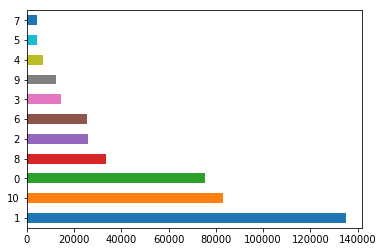

In [17]:
print(df.expression.value_counts())
pd.value_counts(df.expression).plot.barh()

In [18]:
df = df[df.expression != 8]  # No-expression
df = df[df.expression != 9]  # Uncertain
df = df[df.expression != 10]  # No-Face

Now we have reduced by ~ 25% but it's still lots of data to work with.

In [19]:
print(df.shape)

(291652, 10)


1    134916
0     75374
2     25959
6     25382
3     14590
4      6878
5      4303
7      4250
Name: expression, dtype: int64


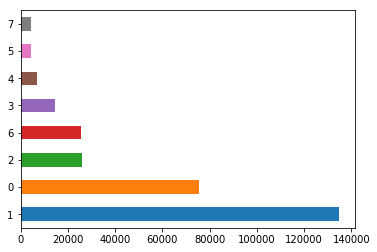

In [20]:
print(df.expression.value_counts())
pd.value_counts(df.expression).plot.barh()

We can see that the classes in the data is heavily imbalanced, But Jeremy in last class asked us not worry too much about the class imbalance. There are actually few things we could do to decrease the class imbalance.
* We could delete some entries of the over-represented class.
* We could make some more copies of the under-represented class.

Since we have enough data, we will drop about half of the class `1` and one-third of class `0` from out data. we will also replicate 50% of class `7` and `5`.
We need to note that, because of replication its possible that same pic might ends up in both training and testing set, hence biasing the test accuracy upwards.

In [21]:
import numpy as np

In [22]:
np.random.seed(42)

In [23]:
# 134916/2 ~ 67000
drop_indices = np.random.choice(df[df.expression == 1].index, 67000, replace=False)
df.drop(drop_indices, inplace=True)
df.reset_index(inplace=True)
print(df.shape)

(224652, 11)


In [24]:
# 75374/3 ~ 25000
drop_indices = np.random.choice(df[df.expression == 0].index, 25000, replace=False)
df.drop(drop_indices, inplace=True)
# df.reset_index(inplace=True)
print(df.shape)

(199652, 11)


We can make the copies of classes `5` and `7` post generating the cropped faces.

We can note that the cropped pics have varying heights and widths. we could choose to resize them while cropping it (this reduces the size of the data-set drastically, making it easy to move it across machines).

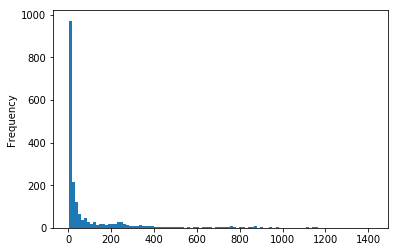

In [25]:
df.face_width.value_counts(ascending=False)[:10]
_ = pd.value_counts(df.face_height, ascending=False)
_.plot.hist(bins=100)

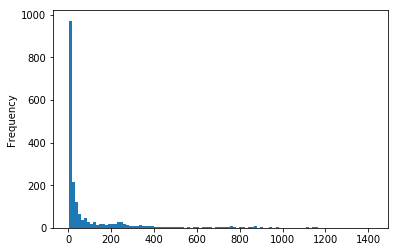

In [26]:
df.face_width.value_counts(ascending=False)[:10]
_ = pd.value_counts(df.face_width)
_.plot.hist(bins=100)

In [27]:
dest_folder = path/'cropped/'

In [76]:
def resize_image(path, sz=(196, 196)):
    im = read_image(path)
    return cv2.resize(im, sz)


def prepare_img(x):
    try:
        r_img = resize_image(path/'Manually_Annotated_Images'/x['subDirectory_filePath'])
        n = emotional_categories[x['expression']] + \
            '_' + x['subDirectory_filePath'].split('/')[-1].split('.')[0] + '.jpg'
        cv2.imwrite(str(dest_folder/n), cv2.cvtColor(r_img, cv2.COLOR_RGB2BGR))
    except:
        print(x['subDirectory_filePath'])

In [77]:
jobs_list = df[['subDirectory_filePath', 'expression']].to_dict('records')

Now one should try to use the tools from fastai.vision module for transformation etc., these functions are effecient in utilising the CPU as they are run as multiprocess jobs.
We should also set up multiprocess jobs for the above transformations efficiently and save us some time.

In [78]:
from multiprocessing import Pool
POOL_SIZE = 6

In [79]:
p = Pool(POOL_SIZE)
p.map(prepare_img, jobs_list);

2/9db2af5a1da8bd77355e8c6a655da519a899ecc42641bf254107bfc0.jpg


In [80]:
len(jobs_list)

199652

In [83]:
[df.subDirectory_filePath == '2/9db2af5a1da8bd77355e8c6a655da519a899ecc42641bf254107bfc0.jpg']

,level_0,index,subDirectory_filePath,face_x,face_y,face_width,face_height,facial_landmarks,expression,valence,arousal
167618,315313,315313,2/9db2af5a1da8bd77355e8c6a655da519a899ecc42641...,NaN,NaN,-1,-1,NaN,1,0.480921,0.094607


In [85]:
df = df[df.subDirectory_filePath != '2/9db2af5a1da8bd77355e8c6a655da519a899ecc42641bf254107bfc0.jpg']

In [86]:
df.shape

(199651, 11)

In [87]:
df.to_csv(str(path/'consolidated.csv'))

You can use the following bash commands to create copy images of desired class.

In [15]:
# To copy all the images of Surprise tag to a temp directory
# ! find -type f | grep 'Surprise' |  xargs -i cp {} ../temp/
# Randomly delete files keeping only n of them
# find ../temp/ -type f -print0 | sort -zR | tail -zn +{n} | xargs -0 rm
# rename the files by appending a 1 to the end
# rename 's/.jpg/1.jpg/' *
# move it back to the source
# mv * ../cropped

Training the model
-----------

In [1]:
from fastai import *
from fastai.vision import *

In [2]:
bs = 96

In [3]:
pat = r'/([^/]+)_'

In [23]:
fnames = get_image_files(path/'cropped')
fnames[:5]

[PosixPath('/home/jupyter/self/AffectNetNew/cropped/Anger_707d199aa32c3c3951828738806979d24e21523bb99324ba7493cc0a.jpg'),
 PosixPath('/home/jupyter/self/AffectNetNew/cropped/Anger_c6f38a3421e21268858ae4ad29b36ad44a2de5a838212a3cdfc5633e.jpg'),
 PosixPath('/home/jupyter/self/AffectNetNew/cropped/Sadness_1e03c8928a8f054c12f7eb9080b802270a0c5b509c70ddcf16f8a1a4.jpg'),
 PosixPath('/home/jupyter/self/AffectNetNew/cropped/Neutral_04f2b7b03fca200fe217a0e2efde62820acd3e5a5617968d5eb0f625.jpg'),
 PosixPath('/home/jupyter/self/AffectNetNew/cropped/Sadness_56ee8227d6146e6836f48feab7d818f6b9f1d688a1cba43e50d14ca3.jpg')]

In [24]:
len(fnames)

204150

Since the images are already cropped to the faces, applying zoom transformation might not be right here, so setting max_zoom to 1 in get_transformation.

In [25]:
data = ImageDataBunch.from_name_re(path/'cropped', fnames, pat,
                                   ds_tfms=get_transforms(max_zoom=1, max_rotate=20),
                                   size=196, bs=bs)
data.normalize(imagenet_stats)

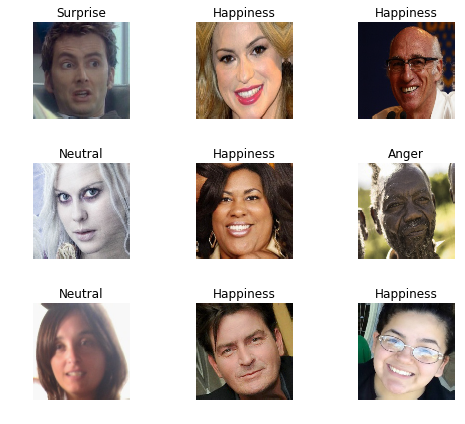

In [26]:
data.show_batch(rows=3, figsize=(7,6))

In [27]:
print(data.classes)
len(data.classes),data.c

['Anger', 'Sadness', 'Neutral', 'Happiness', 'Surprise', 'Disgust', 'Contempt', 'Fear']


(8, 8)

In [28]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)

In [29]:
learn.fit_one_cycle(2)

Total time: 23:44
epoch  train_loss  valid_loss  accuracy
1      1.127556    1.033671    0.630734  (11:51)
2      1.037925    0.975206    0.648402  (11:52)



In [31]:
learn.save('stage-1')

Since imagenet didn't contain any human faces in it, let's we might get a better accuracy once the layers are unfrezed.

In [36]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


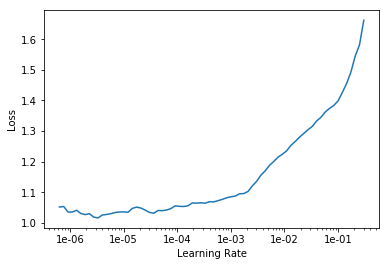

In [37]:
learn.recorder.plot()

In [38]:
learn.unfreeze()

In [39]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

Total time: 32:21
epoch  train_loss  valid_loss  accuracy
1      0.978035    0.926986    0.665997  (15:50)
2      0.948825    0.910005    0.672907  (16:31)



In [40]:
learn.save('stage-2')

In [43]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,5e-5))

Total time: 31:40
epoch  train_loss  valid_loss  accuracy
1      0.918699    0.898093    0.675750  (15:49)
2      0.948922    0.888086    0.679646  (15:51)



In [44]:
learn.save('stage-3')

In [51]:
learn.fit_one_cycle(1, max_lr=slice(1e-6, 1e-3))

Total time: 16:18
epoch  train_loss  valid_loss  accuracy
1      0.893017    0.871769    0.684743  (16:18)



In [52]:
learn.save('stage-t')

In [53]:
learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-4))

Total time: 15:50
epoch  train_loss  valid_loss  accuracy
1      0.885251    0.863854    0.685527  (15:50)



In [54]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

Total time: 33:20
epoch  train_loss  valid_loss  accuracy
1      0.864418    0.863199    0.686066  (16:51)
2      0.851467    0.852486    0.688664  (16:29)



In [56]:
learn.save('stage-4')

In [55]:
interp = ClassificationInterpretation.from_learner(learn)

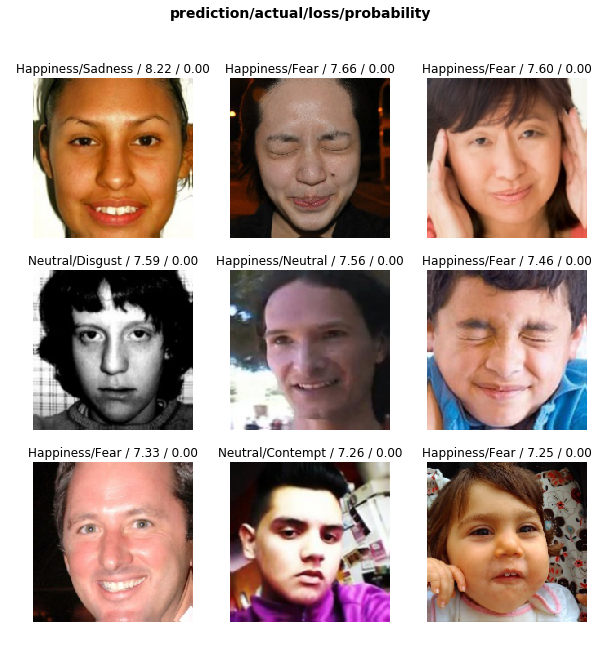

In [58]:
interp.plot_top_losses(9, figsize=(10,10))

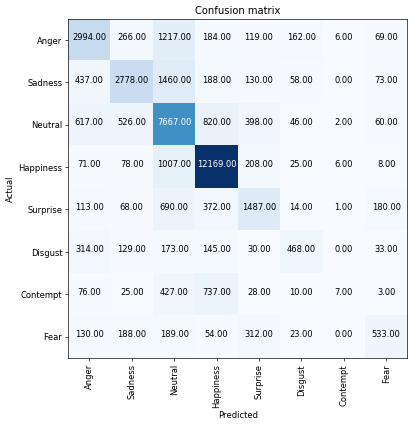

In [60]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=60)

The model is having trouble in classifying classes with low representation in the data set.

In [15]:
learn.fit_one_cycle(2, max_lr=slice(1e-6))

Total time: 24:36
epoch  train_loss  valid_loss  accuracy
1      0.827170    0.795019    0.707627  (12:17)
2      0.830305    0.795934    0.706859  (12:18)

